In [1]:
import sys
from os.path import join, abspath, pardir
from glob import glob
import numpy as np
import pandas as pd
import vaex
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from time import time
from multiprocessing import Pool
import emcee
import corner
from scipy.stats import norm, uniform

In [2]:
root_dir = abspath(pardir)
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/4_Gravity',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [3]:
dpi = 300
from utils import style
style()

In [4]:
root_data_dir = abspath(join(root_dir, "Data"))
data_dir = join(root_data_dir, "MCMC-2")
data_baryon_dir = join(root_data_dir, "Baryon")
data_velocity_dir = join(root_data_dir, "Velocity-Distribution-2")
data_eff_dir = join(root_data_dir, "Effective-Volume-2")

In [5]:
# load baryons components
df_baryon = vaex.open(join(data_baryon_dir, "baryon.hdf5"))
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s
e_rhos = df_baryon["e_rho"].to_numpy()  # Msun/pc^3
e_sigmaz = df_baryon["e_sigma_z"].to_numpy() # km/s

In [6]:
# load data from files
number_files = glob(join(data_eff_dir, "*.hdf5"))
number_files.sort()
velocity_files = glob(join(data_velocity_dir, "gaia_*.hdf5"))
velocity_files.sort()
velocity_popt_files = glob(join(data_velocity_dir, "popt_gaia_*.hdf5"))
velocity_popt_files.sort()

# Do it

gaia_(0.21)_(0.24).hdf5


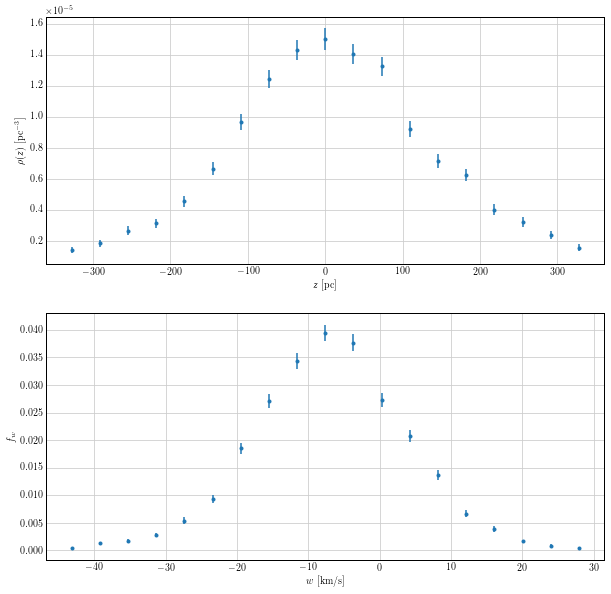

In [7]:
from utils import load_data, plot_data

index = 5
data, dim, w0, sigma_w, a_raw, name = load_data(index, number_files, velocity_files, velocity_popt_files)
print(name)
## plot data
plot_data(data)

## simple

In [8]:
from utils import initialize_prior_mond

## initialize prior
simple = True
cores = 16
locs, scales, uni_list, norm_list = initialize_prior_mond(dim, w0, sigma_w, a_raw, simple=simple)
locs, scales, uni_list, norm_list

({'log_mu0': -2.3025850929940455,
  'log_nu0': -13.815510557964274,
  'zsun': -40,
  'R': 0.0034,
  'w0': array([-27.69535485]),
  'log_sigma_w': array([1.88699691]),
  'a': array([0.69339433])},
 {'log_mu0': 3.401197381662155,
  'log_nu0': 4.605170185988092,
  'zsun': 80,
  'R': 0.0006,
  'w0': array([40]),
  'log_sigma_w': array([0.61903921]),
  'a': array([0.594338])},
 ['log_mu0', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a'],
 ['R'])

In [9]:
from utils import initialize_walkers_mond

## initialize walkers
p0, ndim, nwalkers = initialize_walkers_mond(locs, scales, dim, simple=simple)
p0.shape, ndim, nwalkers

((15, 7), 7, 15)

In [10]:
uni_list, norm_list

(['log_mu0', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a'], ['R'])

In [11]:
from utils import log_posterior_mond

for p00 in p0:
    res = log_posterior_mond(p00, data, locs, scales, dim, norm_list, uni_list, simple=simple)
    print(res)

-4468.906091207514
-6277.152269773908
-17850.92006437294
-16739.531377577725
-4829.233506141633
-7370.672537402494
-1418.7927350406978
-13511.838719472164
-15267.107025206984
-12127.349542790434
-7090.822069866595
-7177.166692641732
-6898.950798303716
-1947.5443590765715
-3619.675029053916


100%|██████████| 500/500 [00:33<00:00, 14.99it/s]


Multiprocessing took 33.5 seconds


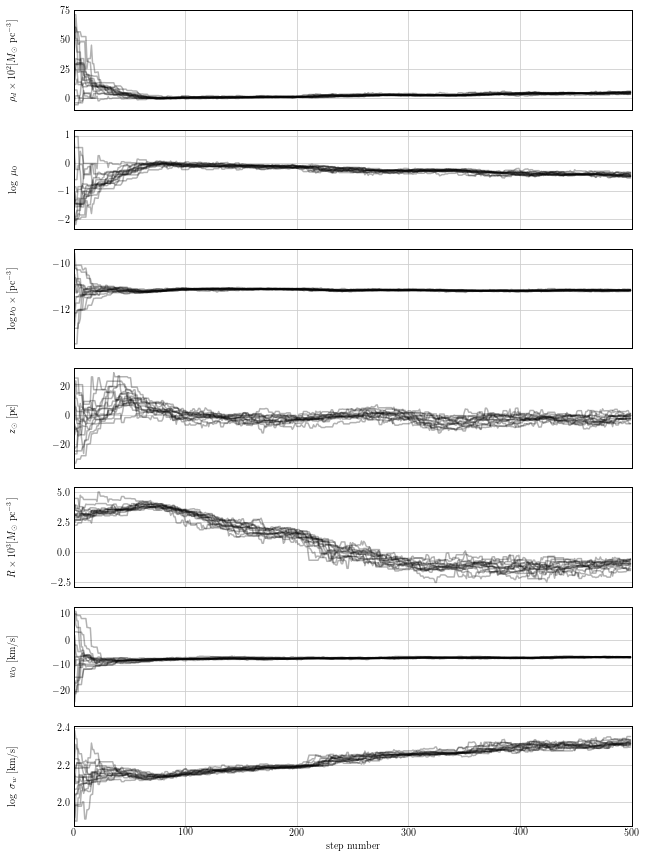

In [12]:
from utils import run_mcmc, consume_samples_mond

sampler = run_mcmc(
    nwalkers, ndim, p0, dim, log_posterior_mond, consume_samples_mond, cores=cores,
    args=[data, locs, scales, dim, norm_list, uni_list, simple], 
    plot=True, step=500, simple=simple
)

100%|██████████| 500/500 [00:33<00:00, 14.84it/s]


Multiprocessing took 33.8 seconds


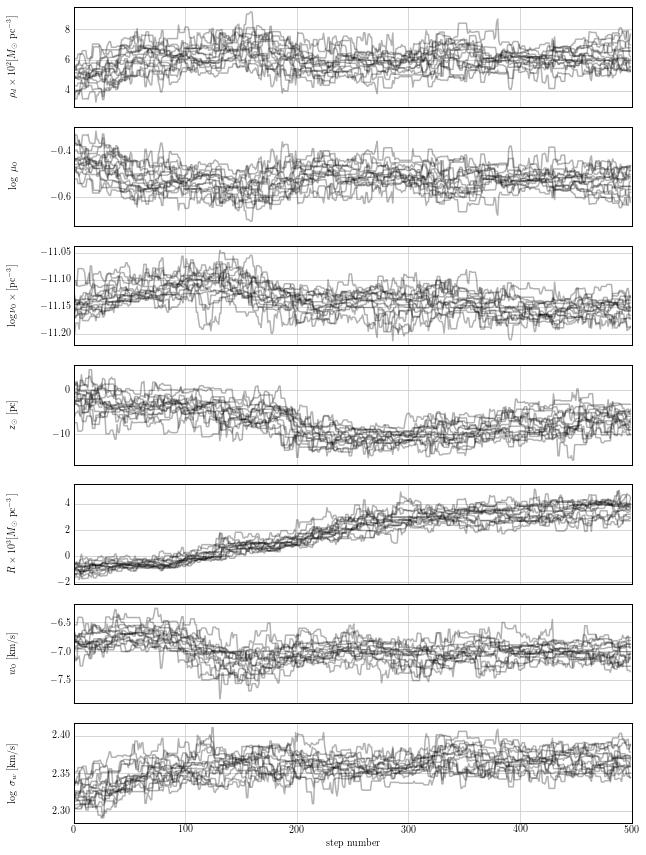

In [13]:
## run again, with the last sample as the initial point
next_p0 = sampler.get_chain()[-1]
sampler_new = run_mcmc(
    nwalkers, ndim, next_p0, dim, log_posterior_mond, consume_samples_mond, cores=cores,
    args=[data, locs, scales, dim, norm_list, uni_list, simple], 
    plot=True, step=500, simple=simple
)

100%|██████████| 2000/2000 [02:09<00:00, 15.49it/s]


Multiprocessing took 129.2 seconds


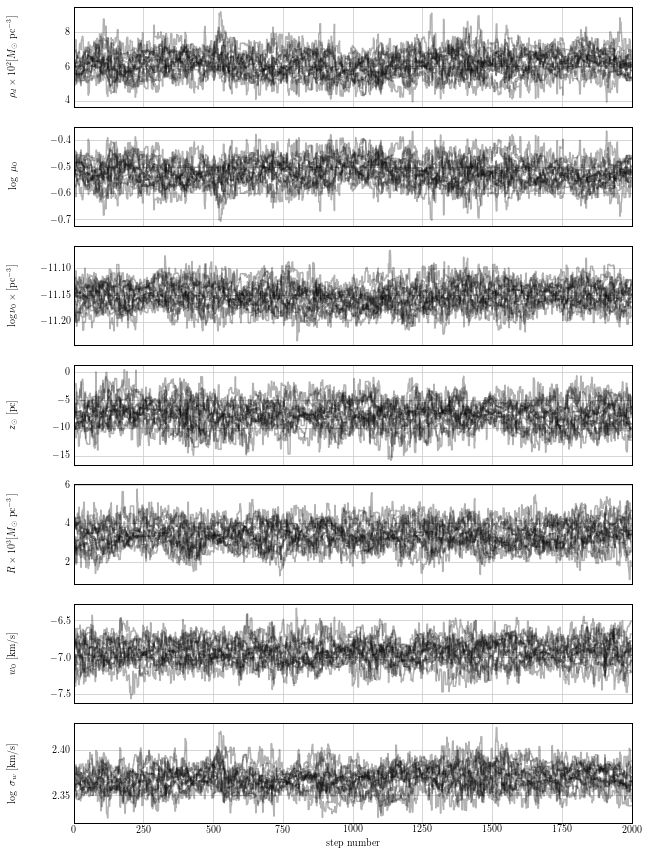

In [15]:
#############################################################################
## run again, with the last sample as the initial point
next_p0 = sampler_new.get_chain()[-1]
sampler_new = run_mcmc(
    nwalkers, ndim, next_p0, dim, log_posterior_mond, consume_samples_mond, cores=cores,
    args=[data, locs, scales, dim, norm_list, uni_list, simple], 
    plot=True, step=2000, simple=simple
)
#############################################################################

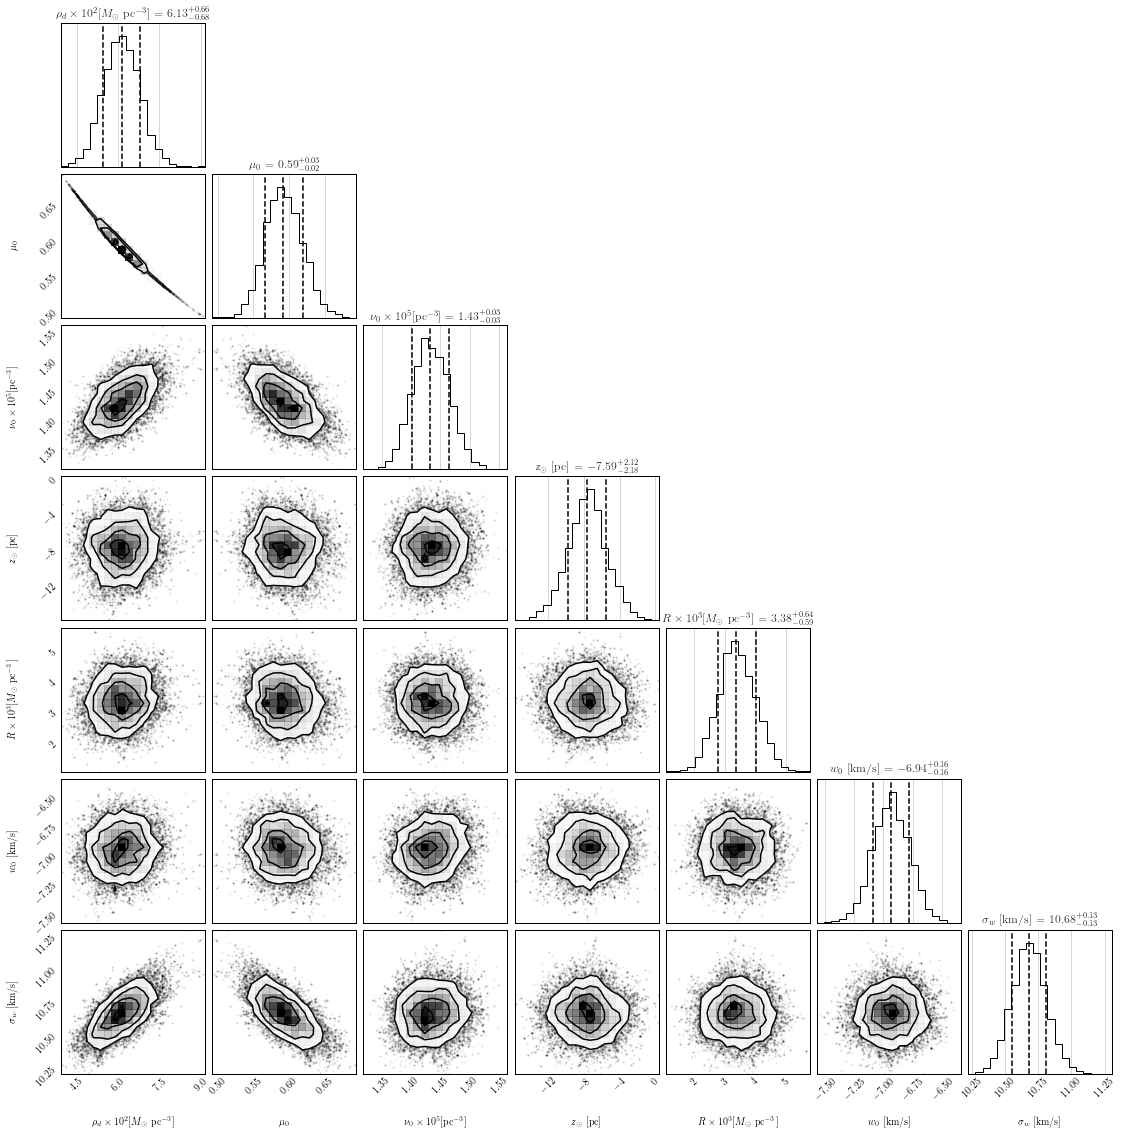

In [16]:
from utils import plot_corner

samples = sampler_new.get_chain()
plot_corner(samples, dim, consume_samples_mond, simple=simple)

100%|██████████| 500/500 [00:11<00:00, 43.55it/s]


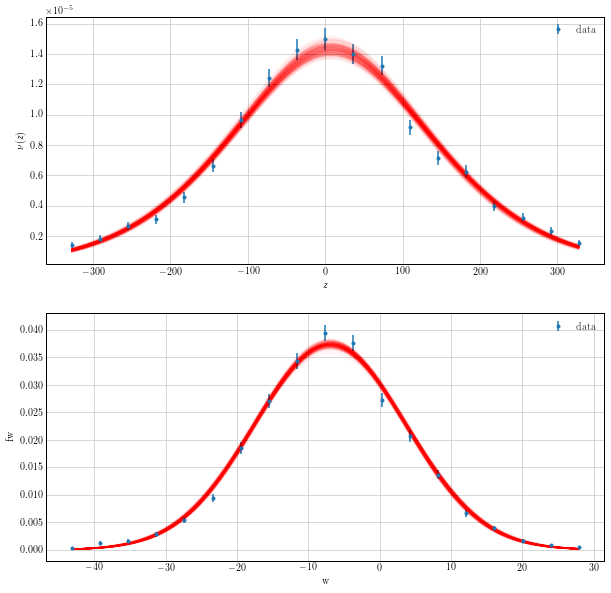

In [17]:
from utils import plot_fitting_mond

plot_fitting_mond(sampler_new, data, dim, alpha=0.01, n=500, simple=simple)

In [18]:
from utils import get_dataframe_mond

df = get_dataframe_mond(sampler_new, dim, locs, scales, norm_list, uni_list, nwalkers, simple=simple)
df

Time: 29.73 s


#,log_mu0,log_nu0,zsun,R,log_prior,log_posterior,log_likelihood,w0_0,log_sigma_w_0,a_0,walker
0,-0.4799154863635059,-11.15974985750781,-5.298192879815103,0.0021041250000767026,-5.655027139156112,341.52895887760815,347.18398601676427,-6.694819767484571,2.3590397226990816,1.2180826656414792,0
1,-0.4799154863635059,-11.15974985750781,-5.298192879815103,0.0021041250000767026,-5.655027139156112,341.52895887760815,347.18398601676427,-6.694819767484571,2.3590397226990816,1.2180826656414792,0
2,-0.4799154863635059,-11.15974985750781,-5.298192879815103,0.0021041250000767026,-5.655027139156112,341.52895887760815,347.18398601676427,-6.694819767484571,2.3590397226990816,1.2180826656414792,0
3,-0.4761545971946899,-11.157362048356083,-4.960123227136645,0.002024328725910229,-5.951109693224955,340.75825239164743,346.7093620848724,-6.669076204927004,2.3583327192507317,1.2498018896957002,0
4,-0.5045838652315171,-11.139641848566304,-7.2512945979361145,0.002842555591396833,-3.754266379790457,344.90802076331585,348.6622871431063,-6.988470343762596,2.3568501443636523,1.052561860297619,0
...,...,...,...,...,...,...,...,...,...,...,...
"29,995",-0.4810907703467798,-11.155026397056114,-10.25499579536263,0.004580619136225709,-5.258595929984075,342.23988659166247,347.49848252164657,-7.073408490396045,2.353814015412459,0.9244703791886598,14
"29,996",-0.5295982068080718,-11.158831424779429,-9.746077219438288,0.004234279901749274,-4.289375665595796,344.35772641165016,348.64710207724596,-7.042563490898464,2.371295785730294,0.9140317258118005,14
"29,997",-0.5295982068080718,-11.158831424779429,-9.746077219438288,0.004234279901749274,-4.289375665595796,344.35772641165016,348.64710207724596,-7.042563490898464,2.371295785730294,0.9140317258118005,14
"29,998",-0.5295982068080718,-11.158831424779429,-9.746077219438288,0.004234279901749274,-4.289375665595796,344.35772641165016,348.64710207724596,-7.042563490898464,2.371295785730294,0.9140317258118005,14


In [19]:
def inv_interpolation_simple(mu):
    return mu/(1-mu)

def inv_interpolation_standard(mu):
    return mu/np.sqrt(1-mu**2)

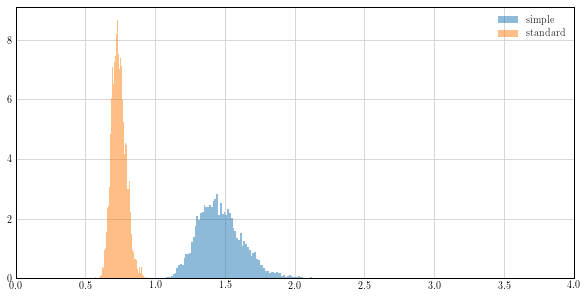

In [20]:
log_mu0 = df['log_mu0'].to_numpy()
mu0 = np.exp(log_mu0)

a0_simple = inv_interpolation_simple(mu0)
a0_standard = inv_interpolation_standard(mu0)

plt.figure(figsize=(10, 5))
plt.hist(a0_simple, bins=100, label="simple", alpha=0.5, density=True)
plt.hist(a0_standard, bins=100, label="standard", alpha=0.5, density=True)
plt.legend()
plt.xlim(0, 4)
plt.show()

## full

In [21]:
## initialize prior
simple = False
cores = 16
locs, scales, uni_list, norm_list = initialize_prior_mond(dim, w0, sigma_w, a_raw, simple=simple)
locs, scales, uni_list, norm_list

({'log_mu0': -2.3025850929940455,
  'log_nu0': -13.815510557964274,
  'zsun': -40,
  'R': 0.0034,
  'w0': array([-27.69535485]),
  'log_sigma_w': array([1.88699691]),
  'a': array([0.69339433]),
  'rhos': array([0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018, 0.0018, 0.0029,
         0.0072, 0.0216, 0.0056, 0.0015]),
  'sigmaz': array([ 3.7,  7.1, 22.1, 39. , 15.5,  7.5, 12. , 18. , 18.5, 18.5, 20. ,
         20. ])},
 {'log_mu0': 3.401197381662155,
  'log_nu0': 4.605170185988092,
  'zsun': 80,
  'R': 0.0006,
  'w0': array([40]),
  'log_sigma_w': array([0.61903921]),
  'a': array([0.594338]),
  'rhos': array([3.12e-03, 5.54e-03, 7.00e-04, 3.00e-05, 6.00e-05, 1.80e-04,
         1.80e-04, 2.90e-04, 7.20e-04, 2.80e-03, 1.00e-03, 5.00e-04]),
  'sigmaz': array([0.2, 0.5, 2.4, 4. , 1.6, 2. , 2.4, 1.8, 1.9, 4. , 5. , 5. ])},
 ['log_mu0', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a'],
 ['R', 'rhos', 'sigmaz'])

In [22]:
## initialize walkers
p0, ndim, nwalkers = initialize_walkers_mond(locs, scales, dim, simple=simple)
p0.shape, ndim, nwalkers

((63, 31), 31, 63)

In [23]:
uni_list, norm_list

(['log_mu0', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a'],
 ['R', 'rhos', 'sigmaz'])

In [24]:
for p00 in p0:
    res = log_posterior_mond(p00, data, locs, scales, dim, norm_list, uni_list, simple=simple)
    if np.isnan(res):
        print(p00)

100%|██████████| 2000/2000 [04:44<00:00,  7.02it/s]


Multiprocessing took 285.0 seconds


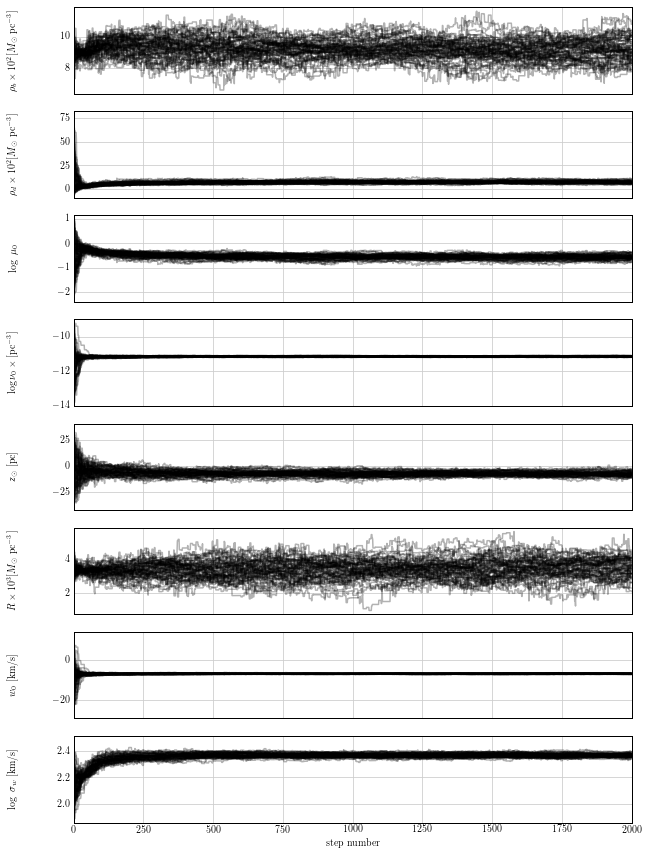

In [26]:
from utils import run_mcmc

sampler = run_mcmc(
    nwalkers, ndim, p0, dim, log_posterior_mond, consume_samples_mond, cores=cores,
    args=[data, locs, scales, dim, norm_list, uni_list, simple], 
    plot=True, step=1000, simple=simple
)

100%|██████████| 2000/2000 [04:43<00:00,  7.05it/s]


Multiprocessing took 284.2 seconds


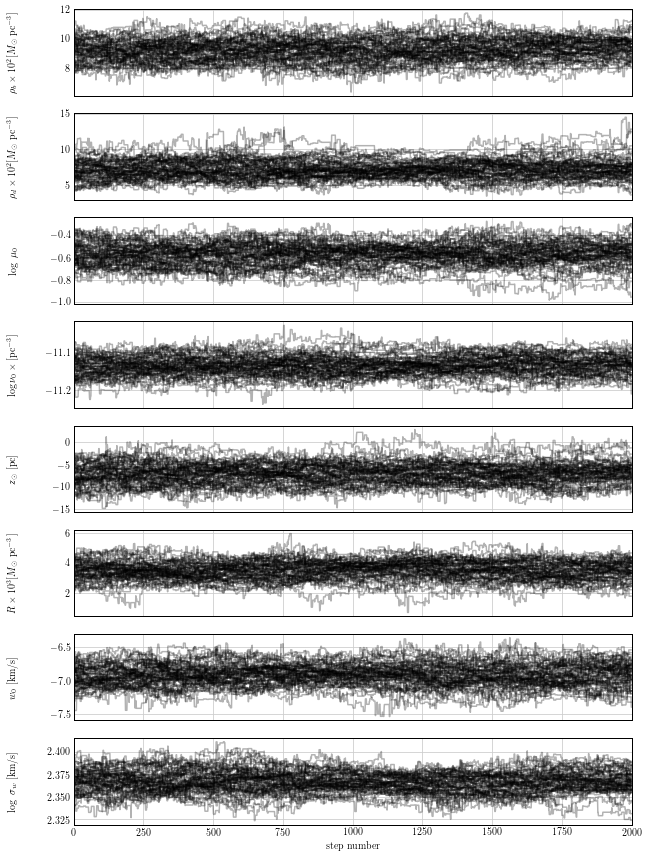

In [27]:
## run again, with the last sample as the initial point
next_p0 = sampler.get_chain()[-1]
sampler_new = run_mcmc(
    nwalkers, ndim, next_p0, dim, log_posterior_mond, consume_samples_mond, cores=cores,
    args=[data, locs, scales, dim, norm_list, uni_list, simple], 
    plot=True, step=2000, simple=simple
)

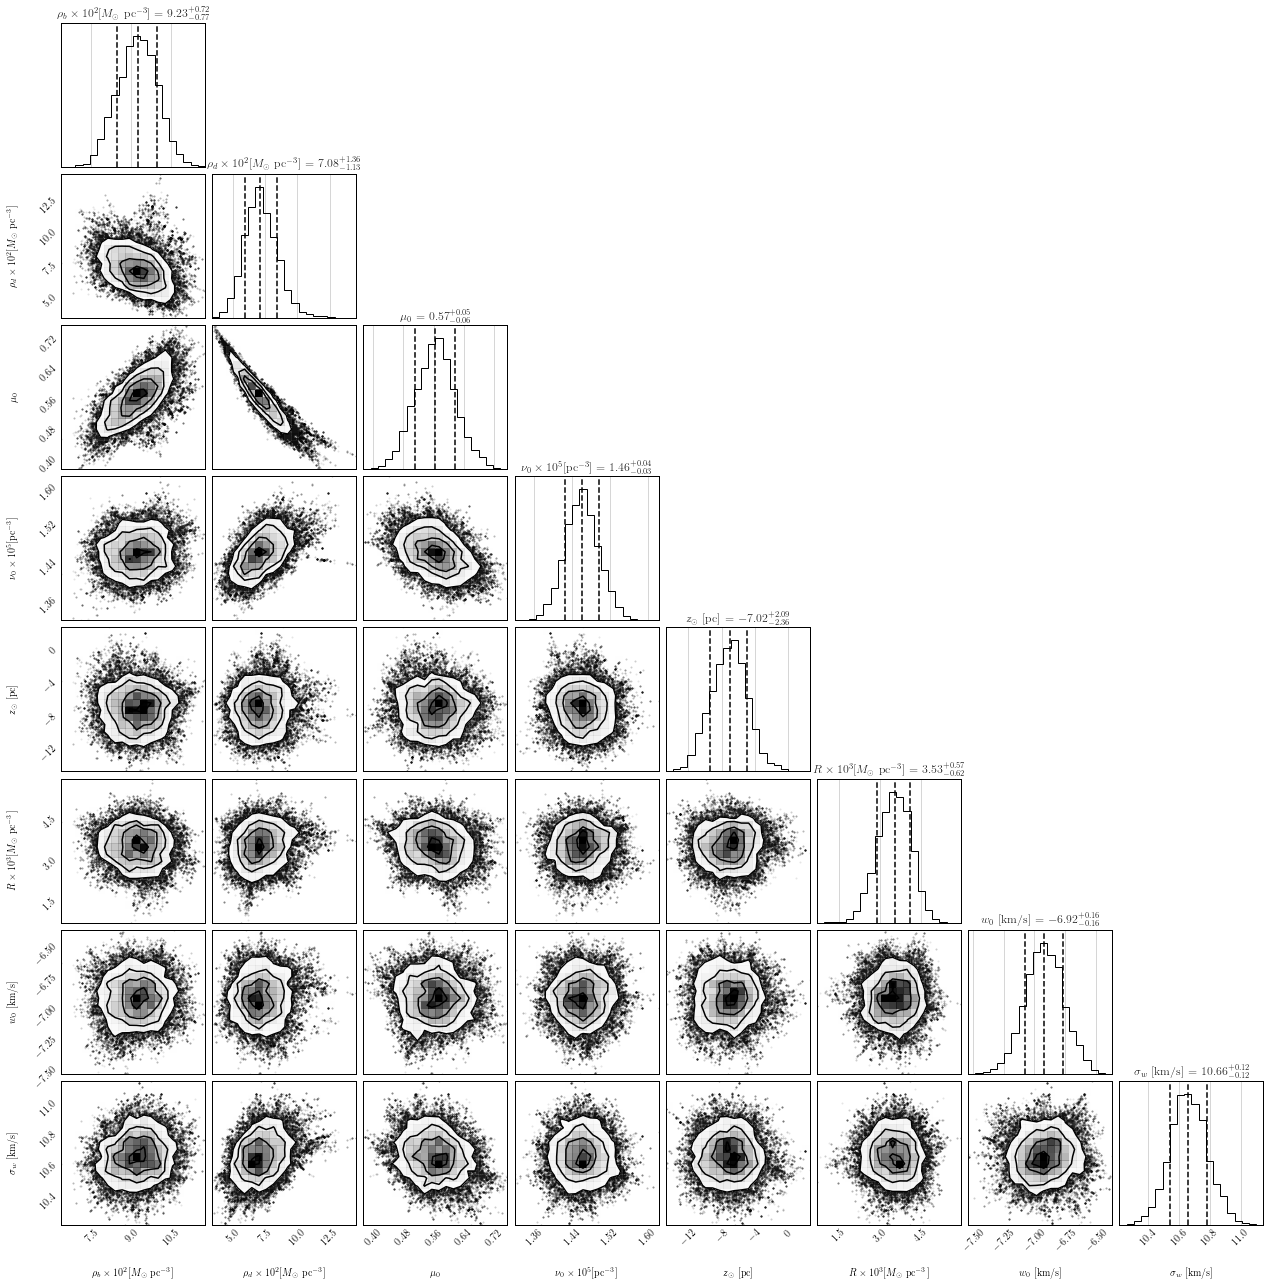

In [28]:
from utils import plot_corner

samples = sampler_new.get_chain()
plot_corner(samples, dim, consume_samples_mond, simple=simple)

100%|██████████| 500/500 [00:11<00:00, 42.98it/s]


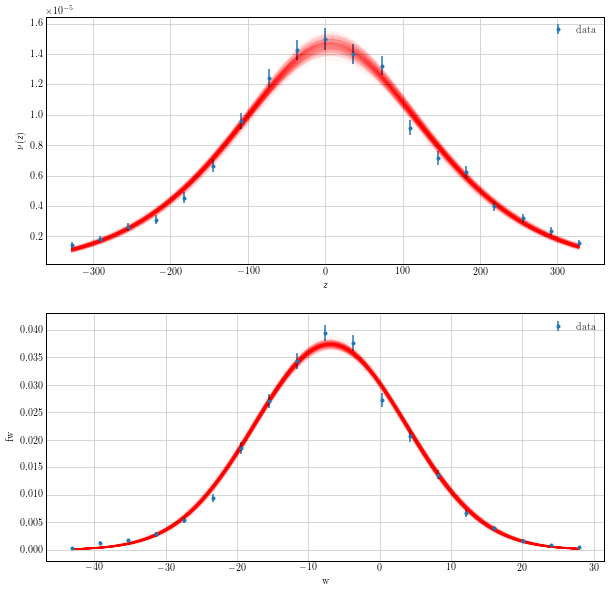

In [29]:
plot_fitting_mond(sampler_new, data, dim, alpha=0.01, n=500, simple=simple)

In [30]:
df = get_dataframe_mond(sampler_new, dim, locs, scales, norm_list, uni_list, nwalkers, simple=simple)
df

Time: 156.19 s


#,log_mu0,log_nu0,zsun,R,log_prior,log_posterior,log_likelihood,w0_0,log_sigma_w_0,a_0,rhob_0,sigmaz_0,rhob_1,sigmaz_1,rhob_2,sigmaz_2,rhob_3,sigmaz_3,rhob_4,sigmaz_4,rhob_5,sigmaz_5,rhob_6,sigmaz_6,rhob_7,sigmaz_7,rhob_8,sigmaz_8,rhob_9,sigmaz_9,rhob_10,sigmaz_10,rhob_11,sigmaz_11,walker
0,-0.4671990820709997,-11.130960406299796,-7.294266237462625,0.003626163197545645,44.41097981155062,393.99949998262343,349.5885201710728,-6.928129560928085,2.3787973613151827,0.7317639074110347,0.007416810429777404,3.9031177075776387,0.03844785267058437,6.041358623122663,0.006979757126169314,23.69595354806896,0.0005203120247818994,34.65120991958504,0.0005803327353355824,15.960045425528937,0.0015907328628806492,5.990588181423245,0.0017093228410014357,10.397321626918623,0.0030403886855596383,14.309540582675165,0.007006700427245606,19.29557919129514,0.027395849768151855,19.753531487583587,0.004432725802639491,20.588751855590083,0.0016349664509727464,26.24978565180374,0
1,-0.4671990820709997,-11.130960406299796,-7.294266237462625,0.003626163197545645,44.41097981155062,393.99949998262343,349.5885201710728,-6.928129560928085,2.3787973613151827,0.7317639074110347,0.007416810429777404,3.9031177075776387,0.03844785267058437,6.041358623122663,0.006979757126169314,23.69595354806896,0.0005203120247818994,34.65120991958504,0.0005803327353355824,15.960045425528937,0.0015907328628806492,5.990588181423245,0.0017093228410014357,10.397321626918623,0.0030403886855596383,14.309540582675165,0.007006700427245606,19.29557919129514,0.027395849768151855,19.753531487583587,0.004432725802639491,20.588751855590083,0.0016349664509727464,26.24978565180374,0
2,-0.4671990820709997,-11.130960406299796,-7.294266237462625,0.003626163197545645,44.41097981155062,393.99949998262343,349.5885201710728,-6.928129560928085,2.3787973613151827,0.7317639074110347,0.007416810429777404,3.9031177075776387,0.03844785267058437,6.041358623122663,0.006979757126169314,23.69595354806896,0.0005203120247818994,34.65120991958504,0.0005803327353355824,15.960045425528937,0.0015907328628806492,5.990588181423245,0.0017093228410014357,10.397321626918623,0.0030403886855596383,14.309540582675165,0.007006700427245606,19.29557919129514,0.027395849768151855,19.753531487583587,0.004432725802639491,20.588751855590083,0.0016349664509727464,26.24978565180374,0
3,-0.4671990820709997,-11.130960406299796,-7.294266237462625,0.003626163197545645,44.41097981155062,393.99949998262343,349.5885201710728,-6.928129560928085,2.3787973613151827,0.7317639074110347,0.007416810429777404,3.9031177075776387,0.03844785267058437,6.041358623122663,0.006979757126169314,23.69595354806896,0.0005203120247818994,34.65120991958504,0.0005803327353355824,15.960045425528937,0.0015907328628806492,5.990588181423245,0.0017093228410014357,10.397321626918623,0.0030403886855596383,14.309540582675165,0.007006700427245606,19.29557919129514,0.027395849768151855,19.753531487583587,0.004432725802639491,20.588751855590083,0.0016349664509727464,26.24978565180374,0
4,-0.46666685597928903,-11.131665650824532,-7.182890007483499,0.0035961984157126645,43.24349411179486,392.65446344426954,349.4109693324747,-6.940100697361386,2.3799627524725175,0.7178592211873009,0.007147235219712269,3.9082763893866748,0.038272288953730055,6.0140382703015,0.006991805326774962,23.770073418526543,0.0005225330904340818,34.25238689864695,0.000579456859991982,16.064250654621233,0.0015770000397605074,5.8388868803696745,0.0016972272374142065,10.328967008175928,0.0030510311479658284,14.101748966000358,0.007017320368208742,19.41724803839612,0.027752733269969868,19.707480693393926,0.004388021227248312,20.644977479231787,0.0016564179216076134,26.174028784457388,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"125,995",-0.5363226206817264,-11.124147679761315,-8.498476597289553,0.003778360110905553,39.05286274459306,392.1589396653126,353.1060769207195,-6.8310570915493765,2.3585932443295885,0.704

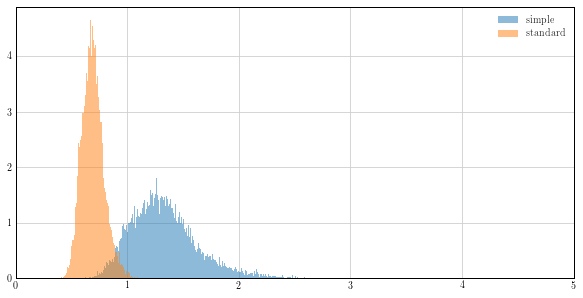

In [31]:
log_mu0 = df['log_mu0'].to_numpy()
mu0 = np.exp(log_mu0)

a0_simple = inv_interpolation_simple(mu0)
a0_standard = inv_interpolation_standard(mu0)

plt.figure(figsize=(10, 5))
plt.hist(a0_simple, bins=300, label="simple", alpha=0.5, density=True)
plt.hist(a0_standard, bins=100, label="standard", alpha=0.5, density=True)
plt.legend()
plt.xlim(0, 5)
plt.show()